In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# 批量归一化

当神经网络深的时候（假设模型结构图损失函数在上，输入在下）。 梯度在上面大，下面小（链式求导多次相乘得出）。上面权重不断跟新，收敛速度可能很快。下面比较底层的特征提取权变化慢，而且底部变化需要顶部重新变化拟合。导致收敛慢。

### 固定小批量里面的均值的方差 

$$\mathrm{BN}(\mathbf{x}) = \boldsymbol{\gamma} \odot \frac{\mathbf{x} - \hat{\boldsymbol{\mu}}_\mathcal{B}}{\hat{\boldsymbol{\sigma}}_\mathcal{B}} + \boldsymbol{\beta}.$$

作用在全连接层和卷基层输出上，激活函数之前。
- 对全连接层，作用在特征维（二维输入，行是样本，列是特征）
- 对卷积层，作用在通道维（把每个像素看作是一个样本）

最初论文事项用它减少内部协变量转移。后续论文指出它可能(不一定正确)就是通过在每个小批量里加入噪音来控制模型复杂度。因为 $\hat{\boldsymbol{\mu}}_\mathcal{B}$ 和 $\hat{\boldsymbol{\sigma}}_\mathcal{B}$ 是当前批次数据的均值和方差，对整体来说也算噪音。

因此没必要和丢弃发混合使用

### 很多时候知识加速收敛，一般不改变模型精度


## 一、从零实现

In [4]:
import torch
from torch import nn
from d2l import torch as d2l

'''
gamma，beta是可学习参数
moving_mean, moving_var是全局均值和方差
eps避免除0
momentum 跟新moving_mean, moving_var
'''
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过 `is_grad_enabled` 来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        #2维是全联接，4维是卷积，其他情况手动实现这里不支持
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 指数移动加权平均
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

创建BatchNorm图层

In [5]:
class BatchNorm(nn.Module):
    # `num_features`：完全连接层的输出数量或卷积层的输出通道数。
    # `num_dims`：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果 `X` 不在内存上，将 `moving_mean` 和 `moving_var`
        # 复制到 `X` 所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的 `moving_mean` 和 `moving_var`
        Y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.9)
        return Y

应用到LeNet

In [6]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

和以前一样，我们将[**在Fashion-MNIST数据集上训练网络**]。
这个代码与我们第一次训练 LeNet（ :numref:`sec_lenet` ）时几乎完全相同，主要区别在于学习率大得多。


loss 0.258, train acc 0.906, test acc 0.869
3721.2 examples/sec on cpu


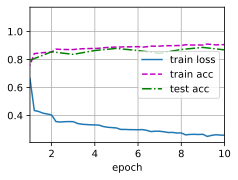

In [7]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

让我们来看看从第一个批量归一化层中学到的[**拉伸参数 `gamma` 和偏移参数 `beta`**]。


In [8]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([1.0864, 2.1881, 0.7582, 2.1934, 1.7011, 1.9852],
        grad_fn=<ViewBackward>),
 tensor([ 1.1013,  0.1060,  0.7803, -0.4211, -2.0584, -0.2459],
        grad_fn=<ViewBackward>))

## 二、简明实现

In [10]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

下面，我们使用相同超参数来训练模型。请注意，通常高级 API 变体运行速度快得多，因为它的代码已编译为 C++ 或 CUDA，而我们的自定义代码由 Python 实现。


loss 0.244, train acc 0.911, test acc 0.861
7086.5 examples/sec on cpu


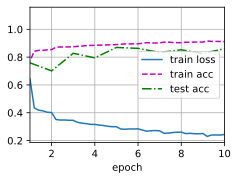

In [12]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 争议

直观地说，批量归一化被认为可以使优化更加平滑。
然而，我们必须小心区分投机直觉和对我们观察到的现象的真实解释。
回想一下，我们甚至不知道简单的神经网络（多层感知机和传统的卷积神经网络）为什么如此有效。
即使在 dropout 和权重衰减的情况下，它们仍然非常灵活，因此无法通过常规的学习理论泛化保证来解释它们是否能够泛化到看不见的数据。

在提出批量归一化的论文中，作者除了介绍了其应用，还解释了其原理：通过减少 *内部协变量偏移*（internal covariate shift）。
据推测，作者所说的“内部协变量转移”类似于上述的投机直觉，即变量值的分布在训练过程中会发生变化。
然而，这种解释有两个问题：
i）这种偏移与严格定义的 *协变量偏移*（covariate shift）非常不同，所以这个名字用词不当。
ii）这种解释只提供了一种不明确的直觉，但留下了一个有待后续挖掘的问题：为什么这项技术如此有效？。
本书旨在传达实践者用来发展深层神经网络的直觉。
然而，重要的是将这些指导性直觉与既定的科学事实区分开来。
最终，当你掌握了这些方法，并开始撰写自己的研究论文时，你会希望清楚地区分技术和直觉。

随着批量归一化的普及，“内部协变量偏移”的解释反复出现在技术文献的辩论，特别是关于“如何展示机器学习研究”的更广泛的讨论中。
Ali Rahimi 在接受 2017 年 NeurIPS 大会的“接受时间考验奖”（Test of Time Award）时发表了一篇令人难忘的演讲。他将“内部协变量转移”作为焦点，将现代深度学习的实践比作炼金术。
他对该示例进行了详细回顾 :cite:`Lipton.Steinhardt.2018` ，概述了机器学习中令人不安的趋势。
此外，一些作者对批量归一化的成功提出了另一种解释：在某些方面，批量归一化的表现出与原始论文 :cite:`Santurkar.Tsipras.Ilyas.ea.2018` 中声称的行为是相反的。

然而，与技术机器学习文献中成千上万类似模糊的声明相比，内部协变量偏移没有什么更值得批评。
很可能，它作为这些辩论的焦点而产生共鸣，要归功于它对目标受众的广泛认可。
批量归一化已经被证明是一种不可或缺的方法。它适用于几乎所有图像分类器，并在学术界获得了数万引用。



## 小结

* 在模型训练过程中，批量归一化利用小批量的均值和标准差，不断调整神经网络的中间输出，使整个神经网络各层的中间输出值更加稳定。
* 批量归一化在全连接层和卷积层的使用略有不同。
* 批量归一化层和 dropout 层一样，在训练模式和预测模式下计算不同。
* 批量归一化有许多有益的副作用，主要是正则化。另一方面，”减少内部协变量偏移“的原始动机似乎不是一个有效的解释。


